<a href="https://colab.research.google.com/github/changbai-phu/Currency_Exchange_Rate_Predict/blob/main/Exchange_Rate_CAD_CNY_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 pandas

In [ ]:
!pip install yfinance

## 1. Data Preparation
- Web scraping exchange rate data and save to a certain format.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [3]:
class CurrencyMonitor:
    def __init__(self):
        self.fetch_exchange_rate()

    # update the url for the corresponding currency rate page, this only scraping CAD and CNY
    def fetch_exchange_rate(self):
        url = "https://g.co/finance/CAD-CNY"
        print("Fetching...")
        #headers = {}
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_format = soup.prettify()
            #holders = soup.find_all('div', class_='YMlKec fxKbKc')
            div_element = soup.find('div', {'data-source':'CAD', 'data-target':'CNY'})
            print(div_element)
            if div_element:
                # print(div_element)
                last_price = div_element.get('data-last-price')
                last_market_timestamp = div_element.get('data-last-normal-market-timestamp')
                unix_timestamp = int(last_market_timestamp)
                last_timestamp_converted = datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                print(f"The last price is: {last_price} for date: {last_timestamp_converted}")
                return(last_timestamp_converted, last_price)
            else:
                print("No matching element")
            # In case if you want to output the reponse to a separate file instead showing in terminal, uncomment below
            # print("Writing to the text file response.txt...")
            # f = open('response.txt', 'w')
            # f.write(soup_format)
            # f.close()

In [5]:
CurrencyMonitor()

Fetching...
The last price is: 5.2186699999999995 for date: 2025-08-06 04:33:24


In [10]:
#google page only has real time data, need to go to yahoo finance for historical data
import yfinance as yf

# Get last 6 months of daily data
df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
df = df[['Close']]
df.reset_index(inplace=True)
df.columns = ['Date', 'Rate']

df.to_csv("cad_cny_history.csv", index=False)
print(df.tail())

/tmp/ipython-input-3523705728.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
[*********************100%***********************]  1 of 1 completed

          Date      Rate
122 2025-07-25  5.243906
123 2025-07-28  5.220485
124 2025-07-29  5.226109
125 2025-07-30  5.209860
126 2025-07-31  5.190529


In [8]:
df.head()

,Date,Rate
0,2025-02-03,4.883466
1,2025-02-04,4.989753
2,2025-02-05,5.010937
3,2025-02-06,5.078317
4,2025-02-07,5.093781


## 2. Model Forecasting

### A. Using prophet: An open-source time series forecasting tool developed by Meta. It is a Bayesian statistical modelin.
- https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2rfqia1l/nbcgcl6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2rfqia1l/7_1wozyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71368', 'data', 'file=/tmp/tmp2rfqia1l/nbcgcl6l.json', 'init=/tmp/tmp2rfqia1l/7_1wozyw.json', 'output', 'file=/tmp/tmp2rfqia1l/prophet_modelp6g8e2dt/prophet_model-20250806045256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:52:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


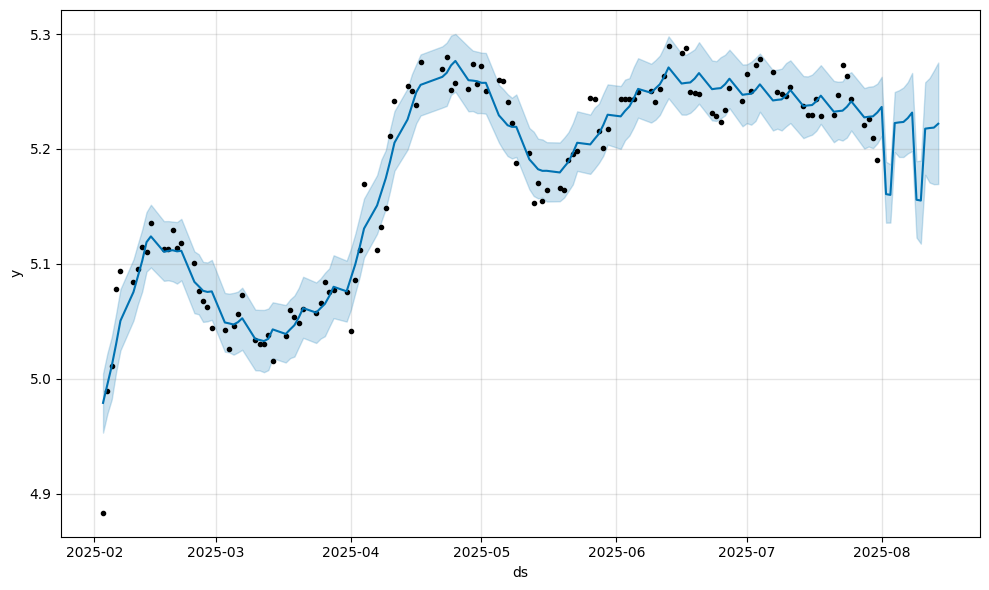

In [11]:
from prophet import Prophet

# Load data
df = pd.read_csv('cad_cny_history.csv')
df = df[['Date', 'Rate']]
df.columns = ['ds', 'y']  # ds:datestamp, y:target value

# Model
model = Prophet()
model.fit(df)

# Forecast
future = model.make_future_dataframe(periods=14) #forecast 14 days
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)

In [12]:
forecast_14 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_14)

            ds      yhat  yhat_lower  yhat_upper
0   2025-02-03  4.979065    4.953213    5.004548
1   2025-02-04  4.995211    4.969562    5.022244
2   2025-02-05  5.011180    4.982086    5.036312
3   2025-02-06  5.030143    5.005597    5.056496
4   2025-02-07  5.050540    5.024751    5.078013
..         ...       ...         ...         ...
136 2025-08-10  5.155130    5.117604    5.189983
137 2025-08-11  5.217662    5.177520    5.258033
138 2025-08-12  5.218215    5.170812    5.261748
139 2025-08-13  5.218591    5.169358    5.268257
140 2025-08-14  5.221961    5.169504    5.275207

[141 rows x 4 columns]


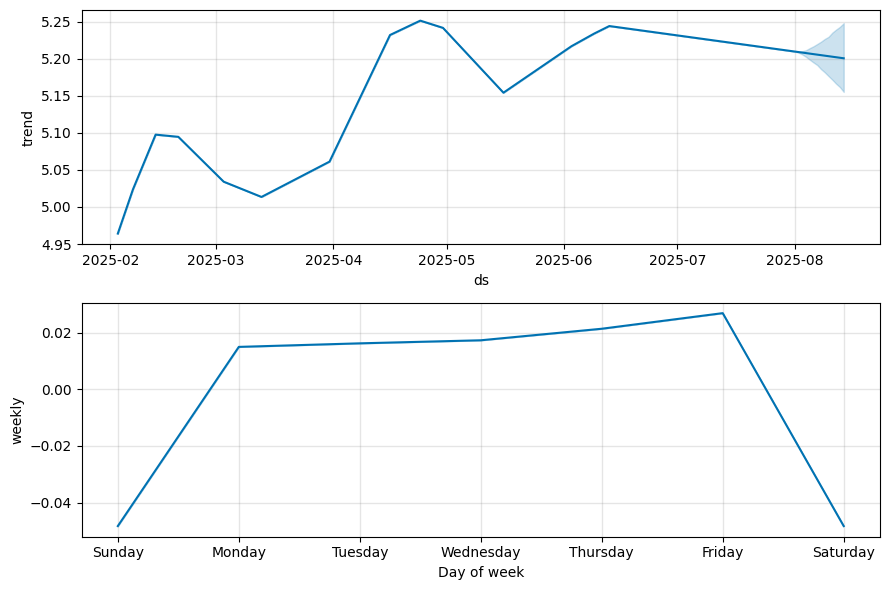

In [13]:
fig2 = model.plot_components(forecast)

In [15]:
# Interactive figure
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

### B. Using ARIMA

### C. Using LSTM/RNN/Transformer